In [2]:
#!/usr/bin/env python
# coding: utf-8
# Thorpe scale approach in the Weddell Sea
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mixsea as mx
import gsw
import cmocean
from src.read_CTDs import load_Joinville_transect_CTDs
import src.helper as helper
from scipy.interpolate import interp1d  # is considered legacy code, will be in the future removed from scipy
import warnings

In [3]:
plt.rcParams.update({
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "figure.figsize": [8, 6]
})

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
DENSITY_NOISE = 5e-4  # Noise parameter, Default value = 5e-4
ALPHA = 0.8  # Coefficient relating the Thorpe and Ozmidov scales.
BACKGROUND_EPS = 1e-10  # Background value of epsilon applied where no overturns are detected.
OUTLIERS = ['PS71/216-1', 'PS40/099-1', 'PS49/015-2', 'PS71/212-3', 'PS71/210-2']

In [5]:
CTDs = load_Joinville_transect_CTDs()
CTDs_grouped = CTDs.groupby("Event")
events = CTDs_grouped.groups.keys()

# define a common axis with grid spacing of 1
new_mab = np.arange(0, 5000, 1)

# objects for saving the data later    
eps_df = pd.DataFrame()
LT_df = pd.DataFrame()
N_df = pd.DataFrame()
T_df = pd.DataFrame()
gamma_n_df = pd.DataFrame()

loading of ../../data/CTD/joinville_transect_ctds_incl_neutral_density.csv was successful
renaming of matlab style columns
Var1 	 index
Event 	 Event
Latitude 	 Latitude
Longitude 	 Longitude
Press_dbar_ 	 Press [dbar]
Sal 	 Sal
Temp__C_ 	 Temp [°C]
AbsoluteSalinity 	 Absolute Salinity
ConservativeTemperature 	 Conservative Temperature
Date_Time 	 Date/Time
DepthWater_m_ 	 Depth water [m]
Expedition 	 Expedition
neutral_density 	 Neutral density [kg m^-3]


In [6]:
CTDs

,Event,Latitude,Longitude,Press [dbar],Sal,Temp [°C],Absolute Salinity,Conservative Temperature,Date/Time,Depth water [m],Expedition,Neutral density [kg m^-3]
index,,,,,,,,,,,,
0,PS129_100_03,-64.2810,-47.4670,2,34.0119,-1.8516,34.178135,-1.847690,2022-04-19 22:48:30,1.980490,PS129,27.607695
1,PS129_100_03,-64.2810,-47.4670,3,34.0117,-1.8519,34.177921,-1.848007,2022-04-19 22:48:30,2.970727,PS129,27.607518
2,PS129_100_03,-64.2810,-47.4670,4,34.0122,-1.8555,34.178410,-1.851625,2022-04-19 22:48:30,3.960960,PS129,27.608094
3,PS129_100_03,-64.2810,-47.4670,5,34.0123,-1.8562,34.178497,-1.852341,2022-04-19 22:48:30,4.951188,PS129,27.608210
4,PS129_100_03,-64.2810,-47.4670,6,34.0125,-1.8567,34.178685,-1.852858,2022-04-19 22:48:30,5.941411,PS129,27.608414
...,...,...,...,...,...,...,...,...,...,...,...,...
291032,PS117_93-1,-63.2557,-53.4054,381,34.5890,-0.8440,NaN,NaN,2019-01-31 22:21:00,377.000000,PS117,28.228339
291033,PS117_93-1,-63.2557,-53.4054,382,34.5890,-0.8431,NaN,NaN,2019-01-31 22:21:00,378.000000,PS117,28.228201
291034,PS117_93-1,-63.2557,-53.4054,383,34.5891,-0.8413,NaN,NaN,2019-01-31 22:21:00,378.900000,PS117,28.228139


In [7]:
for event in events:

    if event in OUTLIERS:
        continue

    current_profile = CTDs_grouped.get_group(event).reset_index(drop=True)

    eps, N2, diagnostics = mx.overturn.eps_overturn(
        current_profile['Depth water [m]'],
        current_profile['Temp [°C]'],
        current_profile['Sal'],
        current_profile["Longitude"].mean(),
        current_profile["Latitude"].mean(),
        dnoise=DENSITY_NOISE,
        alpha=ALPHA,
        background_eps=np.nan, #background will be added later
        return_diagnostics=True,
    )

    N = np.sqrt(N2)  # s* 86400 / (2 * np.pi) # Calculate buoyancy frequency in units of cycles per day (cpd).

    # Plot only in the depth range:
    max_depth = current_profile['Depth water [m]'].max()
    depth = current_profile['Depth water [m]']

    if np.all(np.isnan(N)):
        print(f"{event} only produces NaNs")
        continue

    if max_depth < 200:
        print(f"{event} is only {max_depth}m deep and too shallow")
        continue
    if current_profile['Temp [°C]'].iloc[-1] > 0.2:
        print(f"{event} measures {current_profile['Temp [°C]'].iloc[-1]:.2f} °C at the bottom, which is too high ")
        continue

    # nearest interpolation to the defined axis

    
    LT_func = interp1d(max_depth - depth, diagnostics["Lt"], kind='nearest', bounds_error=False, fill_value=(np.nan, np.nan))    
    N_func = interp1d(max_depth - depth, N, kind='nearest', bounds_error=False, fill_value=(np.nan, np.nan))
    eps_func = interp1d(max_depth - depth, eps, kind='nearest', bounds_error=False, fill_value=(np.nan, np.nan))
    T_func = interp1d(max_depth - depth, current_profile['Temp [°C]'], kind='nearest', bounds_error=False,
                      fill_value=(np.nan, np.nan))
    gamma_n_func = interp1d(max_depth - depth, current_profile['Neutral density [kg m^-3]'], kind='nearest',
                            bounds_error=False,
                            fill_value=(np.nan, np.nan))

    LT_df[current_profile["Longitude"].mean()] = LT_func(new_mab)
    N_df[current_profile["Longitude"].mean()] = N_func(new_mab)
    eps_df[current_profile["Longitude"].mean()] = eps_func(new_mab)
    T_df[current_profile["Longitude"].mean()] = T_func(new_mab)
    gamma_n_df[current_profile["Longitude"].mean()] = gamma_n_func(new_mab)

PS117_66-4 is only 120.8m deep and too shallow
PS18/045-2 measures 0.49 °C at the bottom, which is too high 
PS40/098-1 only produces NaNs
PS40/099-4 only produces NaNs
PS40/100-1 only produces NaNs
PS40/101-1 only produces NaNs
PS40/102-2 only produces NaNs
PS71/210-1 is only 101.0m deep and too shallow


In [8]:
# sort columns after their longitude value
LT_df.sort_index(axis=1, inplace=True)
eps_df.sort_index(axis=1, inplace=True)
N_df.sort_index(axis=1, inplace=True)
T_df.sort_index(axis=1, inplace=True)
gamma_n_df.sort_index(axis=1, inplace=True)

# # small data cleaning
# try:
#     assert T_df.iloc[:, 35].count() < 120
#     print(f"Profile at {T_df.columns[35]:.1f}°W contains only {T_df.iloc[:, 35].count()} values and will be removed")
#     eps_df.drop(T_df.columns[35], axis="columns", inplace=True)
#     N_df.drop(T_df.columns[35], axis="columns", inplace=True)
#     T_df.drop(T_df.columns[35], axis="columns", inplace=True)
#     gamma_n_df.drop(T_df.columns[35], axis="columns", inplace=True)
# except AssertionError:
#     print("Wrong clean up parameters")
#     passb

In [9]:
# removes the super high Thorpe scales, for which no dissipation rate is computed
LT_df.where(cond=~eps_df.isna(), other=np.nan, inplace=True)
# remove all Thorpe scale values larger than 200m, in particular removes one very large overturn in the deep ocean around 47° W
LT_df.where(cond=LT_df<200, other=np.nan, inplace=True)
# communicate changes back to eps_df
eps_df.where(cond=~LT_df.isna(), other=np.nan, inplace=True)

In [10]:
# #LT_df.columns = LT_df.columns.astype("float")
# data = LT_df.iloc[0:602].values.flatten()
# logbins = np.logspace(np.log10(np.nanmin(data)),np.log10(np.nanmax(data)),40)
# plt.hist(data, bins = logbins)
# plt.xscale('log')

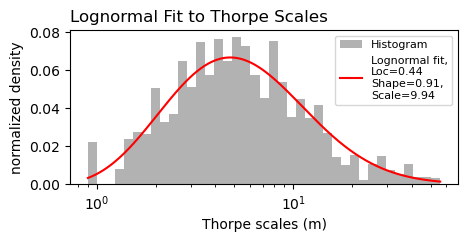

In [36]:
#import numpy as np
#import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Your data
data = LT_df.iloc[0:502].values.flatten()

# Remove NaN values (lognormal fitting does not handle NaNs)
data = data[~np.isnan(data)]

# Fit a lognormal distribution to the data
#shape, loc, scale = lognorm.fit(data, floc=0)  # Setting floc=0 constrains loc to zero
shape, loc, scale = lognorm.fit(data)#, floc=0.7)  # Setting floc=0 constrains loc to zero

# Generate logbins for the histogram
logbins = np.logspace(np.log10(np.nanmin(data)), np.log10(np.nanmax(data)), 40)

# Plot the histogram of the data
plt.hist(data, bins=logbins, density=True, alpha=0.6, color='gray', label='Histogram')
plt.xscale('log')

# Generate the PDF for the fitted lognormal distribution
x = np.logspace(np.log10(np.nanmin(data)), np.log10(np.nanmax(data)), 1000)
pdf = lognorm.pdf(x, shape, loc, scale)

# Plot the fitted lognormal distribution
plt.plot(x, pdf, 'r-', label=f'Lognormal fit,\nLoc={loc:.2f}\nShape={shape:.2f},\nScale={scale:.2f}')
#plt.gcf().legend(fontsize = 8)#, loc = "outside upper right")

plt.legend(fontsize=8)

# Labels
plt.xlabel('Thorpe scales (m)')
plt.ylabel('normalized density')
plt.title('Lognormal Fit to Thorpe Scales', loc = "left")
plt.gcf().set_size_inches(5,2)
plt.show()


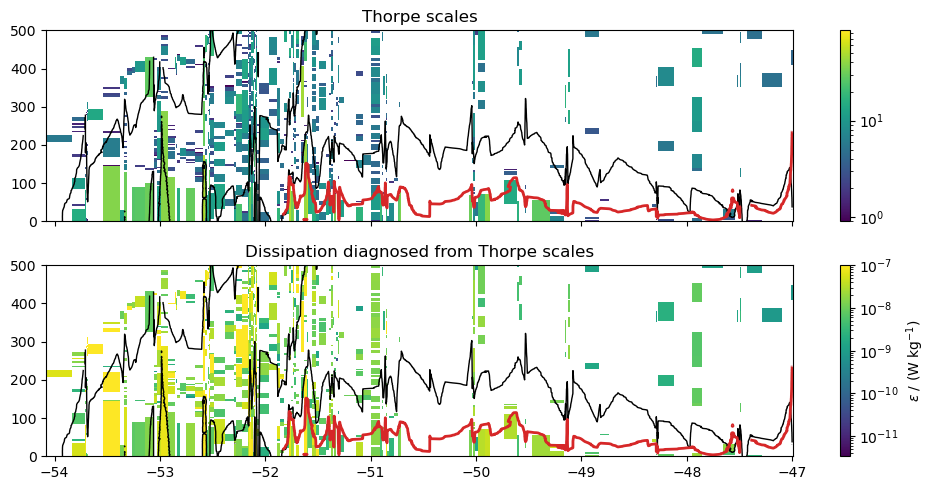

In [59]:
f, ax = plt.subplots(nrows=2, sharex = True, sharey = True, figsize=(10, 5))
# mab_bin_edges = bin_edges(eps_strain_df.index,dz)
# lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)

#LT_df.where(cond=~eps_df.isna(), other=np.nan, inplace=True)

mpp = ax[0].pcolormesh(
    LT_df.columns,
    LT_df.index,
    LT_df,
    norm=mcolors.LogNorm(),
    shading="nearest"
)
cb = plt.colorbar(mpp, ax=ax[0])
#cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
# ax.set_facecolor('lightgrey')
ax[0].set_ylim(0, 500)
ax[0].set_title(r"Thorpe scales")
# helper.Plot.path_as_footnote(fig=f,
#                              path="Pinner_et_al_2024/scripts/thorpe_scales/thorpe_scales.py",
#                              rot="vertical")

levels = [28.00, 28.26, 28.40]
ax[0].contour(
    gamma_n_df.columns,
    gamma_n_df.index,
    gamma_n_df,
    levels=levels,
    colors="k",
    linewidths=1,
)
bottom_density = gamma_n_df.iloc[0]
grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan) # remove everything outside the gravity current
bottom_layer =(grav_curr_bottom_density - gamma_n_df).iloc[:500]
ax[0].contour(
    bottom_layer.columns,
    bottom_layer.index,
    bottom_layer,
    levels=[0.01],
    colors="tab:red",
    linewidths=2,
)

# mab_bin_edges = bin_edges(eps_strain_df.index,dz)
# lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)
mpp = ax[1].pcolormesh(eps_df.columns, eps_df.index, eps_df,
                    norm=mcolors.LogNorm(vmax=1e-7),
                    shading="nearest"
                    )
cb = plt.colorbar(mpp, ax=ax[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
# ax.set_facecolor('lightgrey')
#ax[1].set_ylim(0, 500)
ax[1].set_title(r"Dissipation diagnosed from Thorpe scales")
# helper.Plot.path_as_footnote(fig=f,
#                              path="Pinner_et_al_2024/scripts/thorpe_scales/thorpe_scales.py",
#                              rot="vertical")

levels = [28.00, 28.26, 28.40]
ax[1].contour(
    gamma_n_df.columns,
    gamma_n_df.index,
    gamma_n_df,
    levels=levels,
    colors="k",
    linewidths=1,
)

bottom_layer = (gamma_n_df.iloc[0] - gamma_n_df).iloc[0:500] #> 0.01 

# bottom_density = gamma_n_df.iloc[0]
# bottom_density.where(cond=bottom_density>28.40, other=np.nan, inplace=True)
# bottom_layer2 =(gamma_n_df - bottom_density).iloc[:500]

bottom_density = gamma_n_df.iloc[0]
grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan)
bottom_layer =(grav_curr_bottom_density - gamma_n_df).iloc[:500]
ax[1].contour(
    bottom_layer.columns,
    bottom_layer.index,
    bottom_layer,
    levels=[0.01],
    colors="tab:red",
    linewidths=2,
)

f.tight_layout()

In [60]:
regions = gamma_n_df.where(cond=gamma_n_df<28.40, other = "IL" )
bottom_density = gamma_n_df.iloc[0]
grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan)
regions = regions.where(cond=(grav_curr_bottom_density - gamma_n_df)>0.01, other = "BL" )
regions = regions.where(cond=gamma_n_df > 28.40, other = "open ocean" )
# Define the condition for the column names
condition = lambda col_name: col_name > -52.5
# Create the mask
mask = pd.DataFrame(
    {col: condition(col) for col in regions.columns},  # Check condition on column names
    index=regions.index                                 # Retain the same index
)
regions = regions.where(cond=mask, other = "shelf")
regions = regions.where(cond=~T_df.isna(), other = "air" )
regions = regions.astype("category")
# plt.contourf(
#     regions.columns,
#     regions.index,
#     regions.values,
# )
# plt.colorbar()

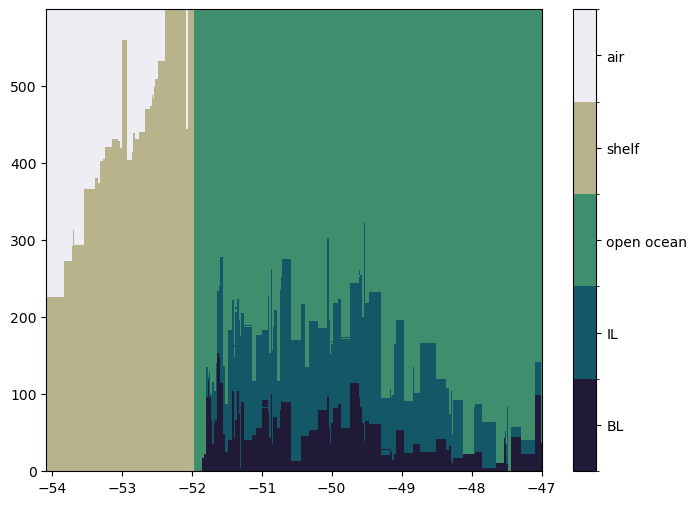

In [97]:
regions_key = {"air":-1, "shelf": 0, "open ocean": 1, "IL":2, "BL":3}
regions = gamma_n_df.where(cond=gamma_n_df<28.40, other = regions_key["IL"] )
bottom_density = gamma_n_df.iloc[0]
grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan)
regions = regions.where(cond=(grav_curr_bottom_density - gamma_n_df)>0.01, other = regions_key["BL"] )
regions = regions.where(cond=gamma_n_df > 28.40, other = regions_key["open ocean"] )
# Define the condition for the column names
condition = lambda col_name: col_name > -52
# Create the mask
mask = pd.DataFrame(
    {col: condition(col) for col in regions.columns},  # Check condition on column names
    index=regions.index                                 # Retain the same index
)
regions = regions.where(cond=mask, other = regions_key["shelf"])
regions = regions.where(cond=~T_df.isna(), other = regions_key["air"] )
regions = regions.iloc[0:600]
levels = np.arange(-1.5,4.5,1)

mpp = plt.pcolormesh(
    regions.columns,
    regions.index,
    regions.values,
    norm = mcolors.BoundaryNorm(levels, ncolors = 256),
    cmap = cmocean.cm.rain
)
cbar = plt.colorbar(mpp, ax=plt.gca(),ticks = list(regions_key.values()))
cbar.set_ticks(ticks =list(regions_key.values()), labels = list(regions_key.keys()))
cbar.ax.invert_yaxis()

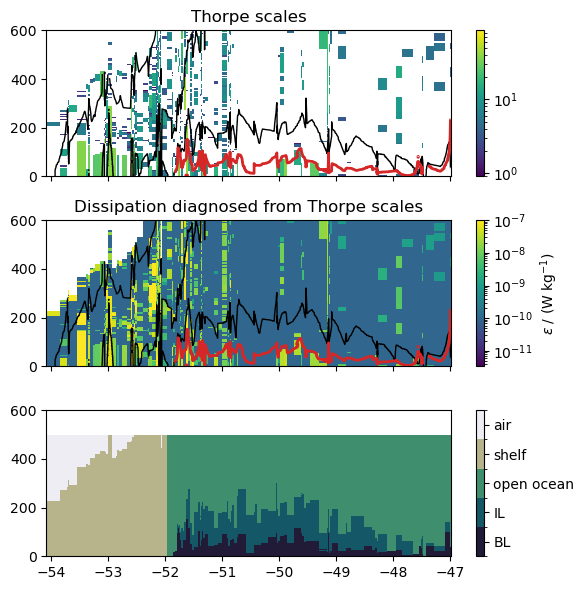

In [94]:
f, ax = plt.subplots(nrows=3, sharex = True, sharey = True, figsize=(6, 6))
# mab_bin_edges = bin_edges(eps_strain_df.index,dz)
# lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)

#LT_df.where(cond=~eps_df.isna(), other=np.nan, inplace=True)

mpp = ax[0].pcolormesh(
    LT_df.columns,
    LT_df.index,
    LT_df,
    norm=mcolors.LogNorm(),
    shading="nearest"
)
cb = plt.colorbar(mpp, ax=ax[0])
#cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
# ax.set_facecolor('lightgrey')
ax[0].set_ylim(0, 600)
ax[0].set_title(r"Thorpe scales")
# helper.Plot.path_as_footnote(fig=f,
#                              path="Pinner_et_al_2024/scripts/thorpe_scales/thorpe_scales.py",
#                              rot="vertical")

levels = [28.00, 28.26, 28.40]
ax[0].contour(
    gamma_n_df.columns,
    gamma_n_df.index,
    gamma_n_df,
    levels=levels,
    colors="k",
    linewidths=1,
)
bottom_density = gamma_n_df.iloc[0]
grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan) # remove everything outside the gravity current
bottom_layer =(grav_curr_bottom_density - gamma_n_df).iloc[:500]
ax[0].contour(
    bottom_layer.columns,
    bottom_layer.index,
    bottom_layer,
    levels=[0.01],
    colors="tab:red",
    linewidths=2,
)

# mab_bin_edges = bin_edges(eps_strain_df.index,dz)
# lon_edges = eps_strain_df.columns - np.diff(eps_strain_df.columns)
mpp = ax[1].pcolormesh(eps_df.columns, eps_df.index, eps_df,
                    norm=mcolors.LogNorm(vmax=1e-7),
                    shading="nearest"
                    )
cb = plt.colorbar(mpp, ax=ax[1])
cb.set_label(r"$\varepsilon$ / (W kg$^{-1}$)")
# ax.set_facecolor('lightgrey')
#ax[1].set_ylim(0, 500)
ax[1].set_title(r"Dissipation diagnosed from Thorpe scales")
# helper.Plot.path_as_footnote(fig=f,
#                              path="Pinner_et_al_2024/scripts/thorpe_scales/thorpe_scales.py",
#                              rot="vertical")

levels = [28.00, 28.26, 28.40]
ax[1].contour(
    gamma_n_df.columns,
    gamma_n_df.index,
    gamma_n_df,
    levels=levels,
    colors="k",
    linewidths=1,
)

bottom_layer = (gamma_n_df.iloc[0] - gamma_n_df).iloc[0:600] #> 0.01 

# bottom_density = gamma_n_df.iloc[0]
# bottom_density.where(cond=bottom_density>28.40, other=np.nan, inplace=True)
# bottom_layer2 =(gamma_n_df - bottom_density).iloc[:500]

bottom_density = gamma_n_df.iloc[0]
grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan)
bottom_layer =(grav_curr_bottom_density - gamma_n_df).iloc[:600]
ax[1].contour(
    bottom_layer.columns,
    bottom_layer.index,
    bottom_layer,
    levels=[0.01],
    colors="tab:red",
    linewidths=2,
)

levels = np.arange(-1.5,4.5,1)
mpp = ax[2].pcolormesh(
    regions.columns,
    regions.index,
    regions.values,
    norm = mcolors.BoundaryNorm(levels, ncolors = 256),
    cmap = cmocean.cm.rain
)
cbar = plt.colorbar(mpp, ax=ax[2],ticks = list(regions_key.values()))
cbar.set_ticks(ticks =list(regions_key.values()), labels = list(regions_key.keys()))
cbar.ax.invert_yaxis()
f.tight_layout()

/tmp/ipykernel_5866/2529424816.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eps_df_small.fillna(value=BACKGROUND_EPS, inplace=True)
/tmp/ipykernel_5866/2529424816.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eps_df_small.where(cond=~gamma_n_df.isna(), other=np.nan, inplace=True)


(600, 155) (600, 155)
air nan
shelf 1.1e-07
open ocean 3.8e-09
IL 4.5e-09
BL 2.4e-08


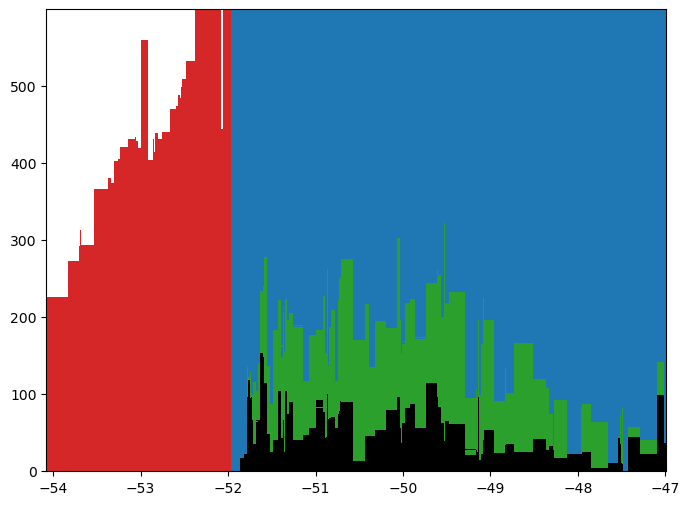

In [98]:
def create_monocolor_colormap(color_name):
    # Define a colormap with the given color fading from white
    return mcolors.LinearSegmentedColormap.from_list(
        name=f"mono_{color_name}",
        colors=[color_name, color_name]
    )
    
eps_df_small = eps_df.iloc[0:600]
gamma_n_df_small = gamma_n_df.iloc[0:600]
eps_df_small.fillna(value=BACKGROUND_EPS, inplace=True)
eps_df_small.where(cond=~gamma_n_df.isna(), other=np.nan, inplace=True)

print(eps_df_small.shape, regions.shape)
assert eps_df_small.shape == regions.shape
logbins = np.logspace(-10, -6, 20)
colors = ["white","tab:red", "tab:blue", "tab:green", "black"]
for (name, number), color in zip(regions_key.items(),colors):
    mean_eps = eps_df_small[regions == number].mean(axis = None)
    print(name, f"{mean_eps:.1e}")
    data = eps_df_small[regions == number]
    plt.pcolormesh(
        data.columns,
        data.index,
        data.values,
        cmap = create_monocolor_colormap(color), 
        label = name
)  

# Binned Data

In [99]:
# binned_neutral_density = pd.read_csv("../../derived_data/binned_neutral_density.csv", index_col = 0)
# binned_neutral_density.columns = binned_neutral_density.columns.astype("float") #convert column names from strings to floats
binned_thorpe_eps = pd.read_csv("../../derived_data/binned_thorpe_dissipation.csv", index_col = 0)
binned_thorpe_eps.columns = binned_thorpe_eps.columns.astype("float") #convert column names from strings to floats

regions_key = {"air":-1, "shelf": 0, "open ocean": 1, "IL":2, "BL":3}
binned_regions = pd.read_csv("../../derived_data/gravity_current_regions.csv", index_col = 0)
binned_regions.columns = binned_regions.columns.astype("float")
binned_regions = binned_regions.iloc[0:600]

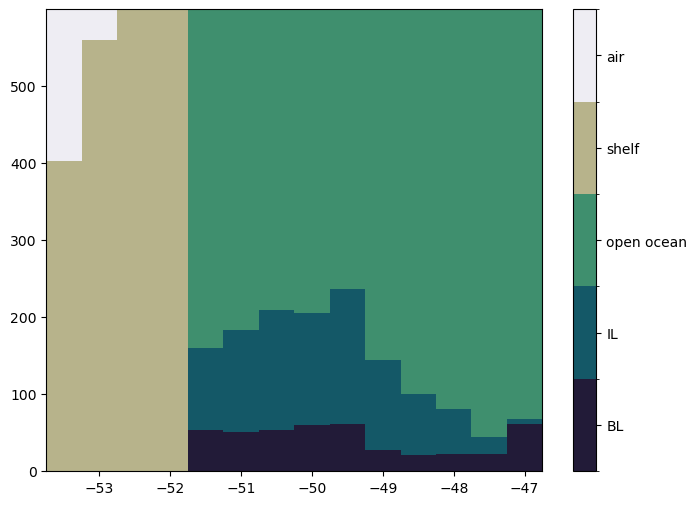

In [100]:
# binned_regions = binned_neutral_density.where(cond=binned_neutral_density<28.40, other = regions_key["IL"] )
# bottom_density = binned_neutral_density.iloc[0]
# grav_curr_bottom_density = bottom_density.where(cond=bottom_density>28.40, other=np.nan)
# binned_regions = binned_regions.where(cond=(grav_curr_bottom_density - binned_neutral_density)>0.01, other = regions_key["BL"] )
# binned_regions = binned_regions.where(cond=binned_neutral_density > 28.40, other = regions_key["open ocean"] )
# # Define the condition for the column names
# condition = lambda col_name: col_name > -52
# # Create the mask
# mask = pd.DataFrame(
#     {col: condition(col) for col in binned_regions.columns},  # Check condition on column names
#     index=binned_regions.index                                 # Retain the same index
# )
# binned_regions = binned_regions.where(cond=mask, other = regions_key["shelf"])
# binned_regions = binned_regions.where(cond=~binned_neutral_density.isna(), other = regions_key["air"] )
# binned_regions = binned_regions.iloc[0:600]
# levels = np.arange(-1.5,4.5,1)
plt.pcolormesh(
    binned_regions.columns,
    binned_regions.index,
    binned_regions.values,
    norm = mcolors.BoundaryNorm(levels, ncolors = 256),
    cmap = cmocean.cm.rain
)
cbar = plt.colorbar(ticks = list(regions_key.values()))
cbar.set_ticks(ticks =list(regions_key.values()), labels = list(regions_key.keys()))
cbar.ax.invert_yaxis()

In [87]:
binned_thorpe_eps_small

,-53.5,-53.0,-52.5,-52.0,-51.5,-51.0,-50.5,-50.0,-49.5,-49.0,-48.5,-48.0,-47.5,-47.0
0,3.429693e-08,2.087713e-08,5.811131e-07,3.078783e-08,3.767688e-08,7.008909e-09,4.626192e-09,1.315087e-08,4.072721e-09,3.261814e-09,1.000000e-10,5.378293e-09,4.392211e-10,1.000000e-10
1,3.429693e-08,2.087713e-08,5.838500e-07,3.078783e-08,3.906510e-08,1.254837e-08,4.626192e-09,1.315087e-08,4.072721e-09,3.261814e-09,1.000000e-10,5.378293e-09,4.392211e-10,1.000000e-10
2,3.429693e-08,2.087713e-08,5.838500e-07,3.078783e-08,3.906510e-08,1.254837e-08,4.626192e-09,1.315087e-08,4.072721e-09,3.261814e-09,9.794022e-10,5.378293e-09,4.392211e-10,1.000000e-10
3,3.429693e-08,2.087713e-08,5.838500e-07,3.078783e-08,3.906510e-08,1.208918e-08,4.626192e-09,1.315087e-08,4.072721e-09,3.261814e-09,9.794022e-10,5.378293e-09,1.033135e-09,1.000000e-10
4,3.332876e-08,2.087713e-08,5.838500e-07,3.078783e-08,3.927007e-08,1.208918e-08,4.626192e-09,1.315087e-08,4.072721e-09,3.261814e-09,1.548862e-09,5.378293e-09,6.939137e-10,1.000000e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NaN,NaN,1.000000e-10,7.441654e-09,1.152275e-08,3.041609e-09,1.000000e-10,2.499518e-09,1.000000e-10,5.411630e-09,1.965594e-10,1.000000e-10,2.020728e-10,1.000000e-10
596,NaN,NaN,1.000000e-10,7.441654e-09,1.182461e-08,3.041609e-09,1.000000e-10,2.499518e-09,1.000000e-10,5.411630e-09,1.000000e-10,1.000000e-10,2.020728e-10,1.000000e-10
597,NaN,NaN,1.000000e-10,8.406857e-09,1.252620e-08,3.041609e-09,1.000000e-10,2.499518e-09,1.000000e-10,5.411630e-09,1.000000e-10,1.000000e-10,2.020728e-10,1.000000e-10
598,NaN,NaN,1.000000e-10,8.406857e-09,1.252620e-08,3.156747e-09,1.000000e-10,2.499518e-09,1.000000e-10,5.411630e-09,1.783126e-10,1.000000e-10,2.020728e-10,1.000000e-10


air nan
shelf 8.7e-08
open ocean 2.4e-09
IL 4.6e-09
BL 9.2e-09


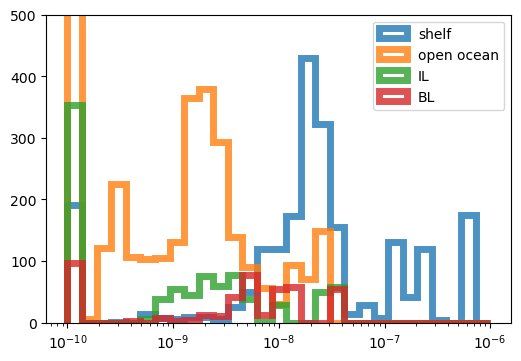

In [101]:
binned_thorpe_eps_small = binned_thorpe_eps.iloc[0:600]
assert binned_thorpe_eps_small.shape == binned_regions.shape
logbins = np.logspace(-10, -6, 30)
fig, ax = plt.subplots(1, figsize = (6,4))
for name, number in regions_key.items():
    mean_eps = binned_thorpe_eps[binned_regions == number].mean(axis = None)
    #std_eps = np.nanstd(binned_thorpe_eps[binned_regions == number].values)
    print(name, f"{mean_eps:.1e}") #+- {std_eps:.1e}")
    data = binned_thorpe_eps_small[binned_regions == number].values.flatten()
    data = data[~np.isnan(data)]
    #print(data)
    if name == "air": continue
    #weights = np.ones_like(data)/float(len(data))
    ax.hist(data, bins = logbins, label = name, alpha = 0.8, histtype = "step", lw = 5)
plt.xscale('log')    
plt.gca().set_ylim(0,500)  
plt.legend();

In [68]:
def create_monocolor_colormap(color_name):
    # Define a colormap with the given color fading from white
    return mcolors.LinearSegmentedColormap.from_list(
        name=f"mono_{color_name}",
        colors=["white", color_name]
    )

air nan
shelf 8.7e-08
open ocean 2.4e-09
IL 4.6e-09
BL 9.2e-09


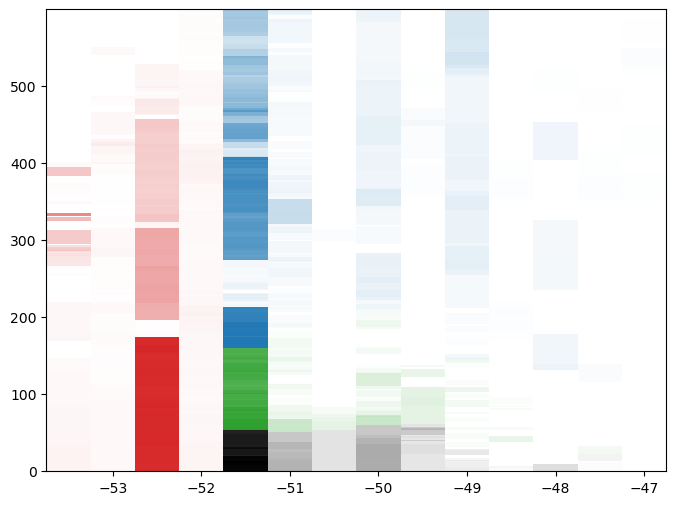

In [69]:
binned_thorpe_eps_small = binned_thorpe_eps.iloc[0:600]
assert binned_thorpe_eps_small.shape == binned_regions.shape
logbins = np.logspace(-10, -6, 20)
colors = ["white","tab:red", "tab:blue", "tab:green", "black"]
for (name, number), color in zip(regions_key.items(),colors):
    mean_eps = binned_thorpe_eps_small[binned_regions == number].mean(axis = None)
    print(name, f"{mean_eps:.1e}")
    data = binned_thorpe_eps_small[binned_regions == number]
    plt.pcolormesh(
        data.columns,
        data.index,
        data.values,
        cmap = create_monocolor_colormap(color), 
        label = name
)  
#plt.legend()

In [70]:
def draw_water_mass_boundaries(axis):
    water_mass_boundaries = [28.26, 28.40] 
    water_mass_names = ['WSDW', 'WSBW'] # water mass names
    CS = axis.contour(
        binned_neutral_density.columns,
        binned_neutral_density.index,
        binned_neutral_density,
        levels=water_mass_boundaries,
        linestyles=["dashed", "solid"],
        colors="k",
        linewidths=3,
        zorder=10
    )
    
    # labeling
    fmt = {}
    for l, s in zip(CS.levels, water_mass_names):
        fmt[l] = s
    # Label every other level using strings
    clabels = axis.clabel(
        CS,
        CS.levels,
        inline=False,
        fmt=fmt,
        colors="black",
        fontsize=11,
    )
    # adjust bboxes for better readability
    [txt.set_bbox(dict(facecolor='lightgrey', alpha = 0.8, edgecolor='darkgrey', boxstyle="round", pad=0)) for txt in clabels]

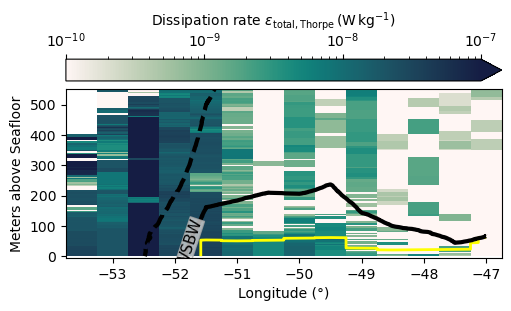

In [71]:
fig, ax = plt.subplots(1, layout = "constrained", figsize = (5,3))
cmap = cmocean.cm.tempo
mpp = ax.pcolormesh(
    binned_thorpe_eps.columns, 
    binned_thorpe_eps.index, 
    binned_thorpe_eps,
    norm=mcolors.LogNorm(vmin=1e-10, vmax=1e-7),
    cmap=cmap,
)

levels = [2.5]
#levels = np.arange(-1.5,4.5,1)
ax.contour(
    binned_regions.columns,
    binned_regions.index,
    binned_regions,
    levels = levels,
    colors = "yellow", #"xkcd:charcoal",
    linewidths=2
)

ax.set_ylim(-5,550)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "max")
cb.set_label(r"Dissipation rate $\varepsilon_{\mathrm{total, Thorpe}}\,$(W$\,$kg$^{-1}$)")
draw_water_mass_boundaries(ax)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");
#fig.savefig("./ppt.png", dpi = 300)

In [72]:
# cut to only cover the core of the gravity current
vertical_eps_df = eps_df.drop(eps_df.columns[eps_df.columns < -51.5], axis="columns")
vertical_eps_df.drop(vertical_eps_df.columns[vertical_eps_df.columns > -48.5], axis="columns", inplace=True)

# Fill NaN with 'assumed_background_dissipation' only where there is temperature data
vertical_eps_df.fillna(value=BACKGROUND_EPS, inplace=True)
vertical_eps_df.where(cond=~T_df.isna(), other=np.nan, inplace=True)
mean_profile = vertical_eps_df.mean(axis=1)
std_of_mean_profile = vertical_eps_df.std(axis=1)

print("done")

done


In [73]:
binned_finestructure_dissipation = pd.read_csv("../../derived_data/binned_finestructure_dissipation.csv", index_col = 0)
binned_finestructure_dissipation.columns = binned_finestructure_dissipation.columns.astype("float") #convert column names from strings to floats

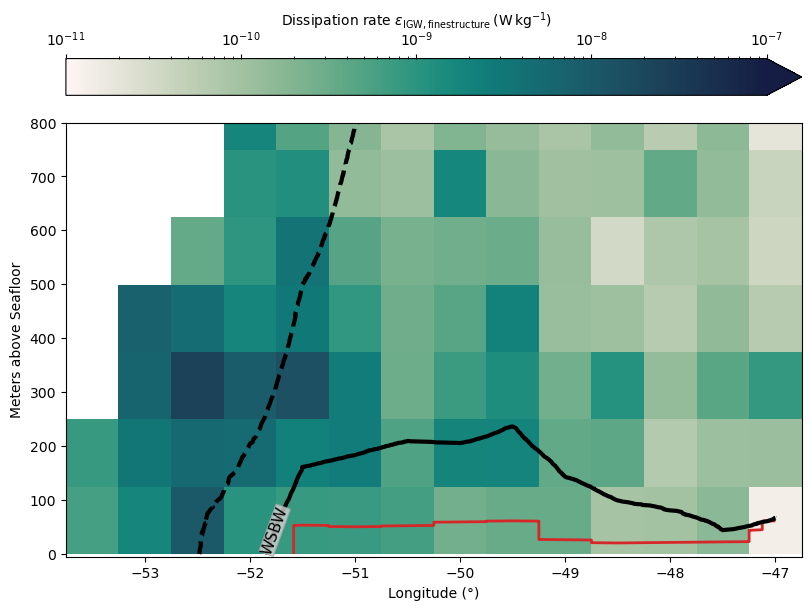

In [74]:
fig, ax = plt.subplots(1, layout = "constrained")
cmap = cmocean.cm.tempo
mpp = ax.pcolormesh(
    binned_finestructure_dissipation.columns, 
    binned_finestructure_dissipation.index, 
    binned_finestructure_dissipation,
    norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-7),
    cmap=cmap,
)

levels = [2.5]
#levels = np.arange(-1.5,4.5,1)
ax.contour(
    binned_regions.columns,
    binned_regions.index,
    binned_regions,
    levels = levels,
    colors = "tab:red",
    linewidths=2
)

ax.set_ylim(-5,800)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "max")
cb.set_label(r"Dissipation rate $\varepsilon_{\mathrm{IGW, finestructure}}\,$(W$\,$kg$^{-1}$)")
draw_water_mass_boundaries(ax)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");

In [75]:
wave_energy_dissipation = pd.read_csv("../../derived_data/wave_energy_dissipation.csv", index_col = 0)

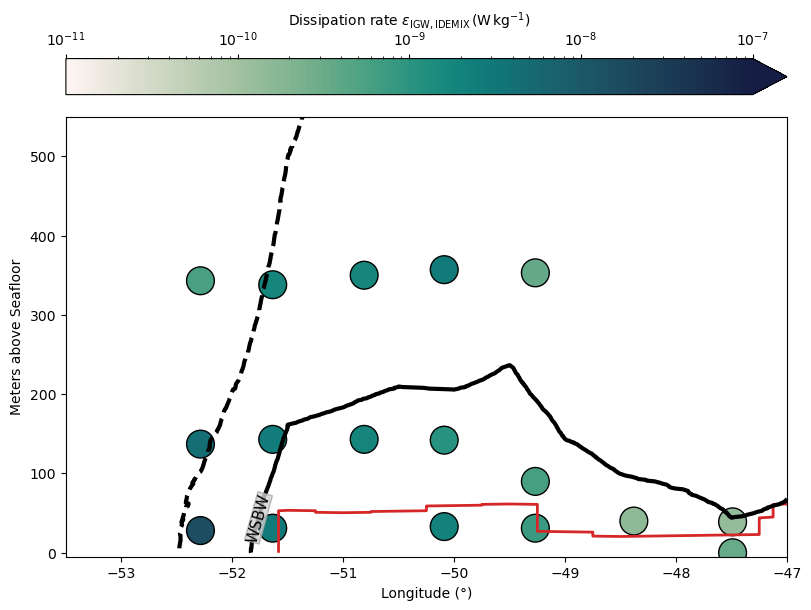

In [76]:
from matplotlib.markers import MarkerStyle
fig, ax = plt.subplots(1, layout = "constrained")
cmap = cmocean.cm.tempo
mpp = ax.scatter(
    wave_energy_dissipation["lon"], 
    wave_energy_dissipation["rounded mab"],
    c = wave_energy_dissipation["eps_IGW"],
    edgecolor="black",
    marker=MarkerStyle("o"),
    s = 400,
    norm=mcolors.LogNorm(vmin=1e-11, vmax=1e-7),
    cmap=cmap,
)

levels = [2.5]
#levels = np.arange(-1.5,4.5,1)
ax.contour(
    binned_regions.columns,
    binned_regions.index,
    binned_regions,
    levels = levels,
    colors = "tab:red",
    linewidths=2
)

ax.set_ylim(-5,550)
cb = plt.colorbar(mpp, ax=ax, location="top", extend = "max")
cb.set_label(r"Dissipation rate $\varepsilon_{\mathrm{IGW, IDEMIX}}\,$(W$\,$kg$^{-1}$)")
draw_water_mass_boundaries(ax)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Meters above Seafloor");